<a href="https://colab.research.google.com/github/natsakh/IAD/blob/main/Pr_6/6_1_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import random

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


<small>[https://docs.pytorch.org/vision/0.8/datasets.html](https://docs.pytorch.org/vision/0.8/datasets.html)</small>

<small>[https://docs.pytorch.org/vision/stable/_modules/torchvision/datasets/mnist.html](https://docs.pytorch.org/vision/stable/_modules/torchvision/datasets/mnist.html)</small>

<small>[https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)</small>


In [2]:
 # MNIST dataset (images 28x28 → tensors in [0,1])
transform = transforms.ToTensor()

full_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# розділимо train → train + val
train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_set, val_set = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=128)

test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 347kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]


In [3]:
# --- Модель: CNN для MNIST ---
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)                            # ↓ розмір у 2 рази
        self.dropout = nn.Dropout(0.25)

        # після двох пулінгів: 28→14→7, отже 64*7*7 ознак
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 класів

    def forward(self, x):
        # x: [B,1,28,28]
        x = F.relu(self.conv1(x))      # [B,32,28,28]
        x = self.pool(x)               # [B,32,14,14]
        x = F.relu(self.conv2(x))      # [B,64,14,14]
        x = self.pool(x)               # [B,64,7,7]
        x = self.dropout(x)
        x = torch.flatten(x, 1)        # [B, 64*7*7]
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)           # [B,10]  (без softmax!)
        return logits

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [4]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable params:", num_params)

Trainable params: 421642


<small>[https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)</small>

In [5]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# stopping параметри
patience = 2   # скільки епох чекати
best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs = 50
best_model_path = "best_model.pth"

In [7]:
# навчання
train_loss_history = []
val_loss_history = []
for epoch in range(n_epochs):

    # --- train ---
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # --- validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    # --- check improvement ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)   #save best model
        print("Saved best model")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping epoch: ", epoch)
            break

[01] train_loss=0.2898 | val_loss=0.0841
Saved best model
[02] train_loss=0.0750 | val_loss=0.0650
Saved best model
[03] train_loss=0.0538 | val_loss=0.0446
Saved best model
[04] train_loss=0.0428 | val_loss=0.0519
[05] train_loss=0.0368 | val_loss=0.0389
Saved best model
[06] train_loss=0.0299 | val_loss=0.0368
Saved best model
[07] train_loss=0.0247 | val_loss=0.0417
[08] train_loss=0.0222 | val_loss=0.0378
Early stopping epoch:  7


In [8]:
best_model = CNN().to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()
print("Best model loaded")

Best model loaded


In [9]:
test_loader = DataLoader(test_set, batch_size=256)

correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:     #  batch of images and labels
        x, y = x.to(device), y.to(device)
        preds = best_model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Test accuracy: {100 * correct / total:.2f}%")

Test accuracy: 99.02%


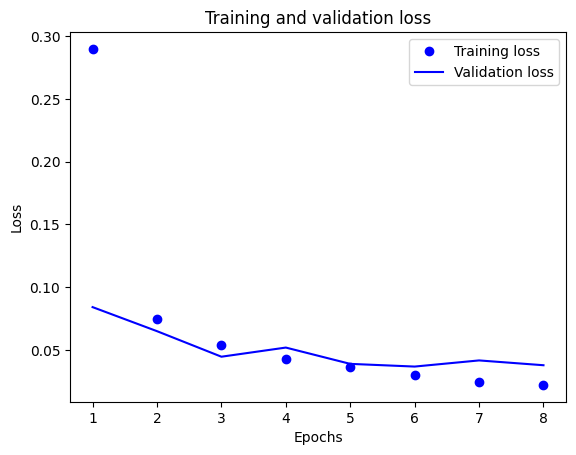

In [10]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)
plt.plot(epochs, train_loss_history, "bo", label="Training loss")
plt.plot(epochs, val_loss_history, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()